In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    print(" TensorFlow loaded successfully")
except ImportError:
    print(" TensorFlow not available. Please install: pip install tensorflow")

# Hugging Face imports
try:
    from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
    import torch
    from datasets import Dataset
    print(" Hugging Face Transformers loaded successfully")
    HF_AVAILABLE = True
except ImportError:
    print(" Hugging Face Transformers not available. Please install: pip install transformers torch datasets")
    HF_AVAILABLE = False

print("="*60)
print("JOB MARKET ANALYSIS - CNN AND HUGGING FACE MODELS")
print("="*60)


 TensorFlow loaded successfully
 Hugging Face Transformers loaded successfully
JOB MARKET ANALYSIS - CNN AND HUGGING FACE MODELS


In [3]:
# Load cleaned data
df = pd.read_csv('/content/cleaned_job_EDA.csv')
df['published_date'] = pd.to_datetime(df['published_date'])
print(f" Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")

 Loaded data: 244656 rows, 30 columns


In [4]:
# TASK 1: CNN FOR JOB CATEGORY CLASSIFICATION
print("\n" + "="*50)
print("TASK 1: CNN FOR JOB CATEGORY CLASSIFICATION")
print("="*50)

# Prepare data for category classification
print(" Preparing data for CNN classification...")

# Remove rows with missing job categories or titles
df_clean = df.dropna(subset=['job_category', 'title_processed'])
df_clean = df_clean[df_clean['title_processed'].str.len() > 0]

print(f" Clean data for classification: {len(df_clean)} jobs")
print(f" Number of categories: {df_clean['job_category'].nunique()}")

# Display category distribution
category_counts = df_clean['job_category'].value_counts()
print("\n Category Distribution:")
for cat, count in category_counts.items():
    print(f"  {cat:<25} {count:>6,} jobs ({count/len(df_clean)*100:>5.1f}%)")

# Encode labels
label_encoder = LabelEncoder()
y_categories = label_encoder.fit_transform(df_clean['job_category'])
num_classes = len(label_encoder.classes_)

print(f"\n  Encoded {num_classes} categories")


TASK 1: CNN FOR JOB CATEGORY CLASSIFICATION
 Preparing data for CNN classification...
 Clean data for classification: 244655 jobs
 Number of categories: 12

 Category Distribution:
  Other                     70,025 jobs ( 28.6%)
  Software Development      56,842 jobs ( 23.2%)
  Design & Creative         31,152 jobs ( 12.7%)
  Marketing & Sales         20,286 jobs (  8.3%)
  Writing & Content         18,035 jobs (  7.4%)
  Customer Support          13,278 jobs (  5.4%)
  Business & Management     11,539 jobs (  4.7%)
  Data & Analytics          10,117 jobs (  4.1%)
  Marketing & Advertising    3,798 jobs (  1.6%)
  Sales & Business Development  3,452 jobs (  1.4%)
  E-commerce & Retail        3,377 jobs (  1.4%)
  Finance & Accounting       2,754 jobs (  1.1%)

  Encoded 12 categories


In [5]:
# Tokenize texts for CNN
max_words = 5000
max_length = 50

tokenizer_cnn = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer_cnn.fit_on_texts(df_clean['title_processed'])

X_text_sequences = tokenizer_cnn.texts_to_sequences(df_clean['title_processed'])
X_text_padded = pad_sequences(X_text_sequences, maxlen=max_length, padding='post', truncating='post')

print(f" Text sequences shape: {X_text_padded.shape}")
print(f" Labels shape: {y_categories.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_text_padded, y_categories,
    test_size=0.2,
    random_state=42,
    stratify=y_categories
)

print(f" Training set: {X_train.shape[0]} samples")
print(f" Testing set: {X_test.shape[0]} samples")

 Text sequences shape: (244655, 50)
 Labels shape: (244655,)
 Training set: 195724 samples
 Testing set: 48931 samples


In [7]:
# Build CNN Model
print("\n Building CNN model for job classification...")

model_cnn = Sequential([
    Embedding(max_words, 128, input_length=max_length),

    # First Conv1D layer
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    # Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model manually before calling count_params
model_cnn.build(input_shape=(None, max_length))

print(" CNN model compiled")
print(f" Model parameters: {model_cnn.count_params():,}")


 Building CNN model for job classification...
 CNN model compiled
 Model parameters: 790,700


In [8]:
# Train CNN model
print("\ Training CNN model...")
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

\ Training CNN model...
Epoch 1/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.6139 - loss: 1.1550 - val_accuracy: 0.9459 - val_loss: 0.2472
Epoch 2/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9257 - loss: 0.3101 - val_accuracy: 0.9575 - val_loss: 0.1702
Epoch 3/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9460 - loss: 0.2321 - val_accuracy: 0.9646 - val_loss: 0.1560
Epoch 4/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9544 - loss: 0.2010 - val_accuracy: 0.9665 - val_loss: 0.1504
Epoch 5/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9573 - loss: 0.1884 - val_accuracy: 0.9659 - val_loss: 0.1497
Epoch 6/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9597 - loss: 0.1767 - val_accuracy: 0.9680 - val_loss: 0.1456
Epoch 7/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9611 - loss: 0.1674 - val_accuracy: 0.9674 - val_loss: 0.1537
Epoch 8/20
3059/3059 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - ac

In [9]:
# Evaluate CNN model
print("\n Evaluating CNN model...")
cnn_predictions = model_cnn.predict(X_test)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

cnn_accuracy = accuracy_score(y_test, cnn_pred_classes)
print(f" CNN Accuracy: {cnn_accuracy:.4f}")

print(f"\n Classification Report:")
print(classification_report(y_test, cnn_pred_classes,
                          target_names=label_encoder.classes_))


 Evaluating CNN model...
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
 CNN Accuracy: 0.9695

 Classification Report:
                              precision    recall  f1-score   support

       Business & Management       0.99      0.98      0.98      2308
            Customer Support       0.98      0.80      0.88      2656
            Data & Analytics       0.98      0.98      0.98      2023
           Design & Creative       0.97      0.96      0.96      6230
         E-commerce & Retail       0.94      0.96      0.95       675
        Finance & Accounting       0.98      0.98      0.98       551
     Marketing & Advertising       0.96      0.95      0.96       760
           Marketing & Sales       0.98      0.99      0.99      4057
                       Other       0.94      0.98      0.96     14005
Sales & Business Development       0.95      0.98      0.96       690
        Software Development       0.99      0.99      0.99     11369
           Writing & Content       0.99    

In [13]:
# TASK 2: SALARY PREDICTION USING CNN
print("\n" + "="*50)
print("TASK 2: SALARY PREDICTION WITH CNN")
print("="*50)

# Prepare salary prediction data
print(" Preparing salary prediction data...")

# Use both hourly and budget data
salary_data = df_clean.copy()
salary_data['target_salary'] = salary_data['avg_hourly_rate'].fillna(0) + \
                              (salary_data['budget'].fillna(0) / 2080)  # Convert budget to hourly equivalent

# Remove extreme outliers
salary_q99 = salary_data['target_salary'].quantile(0.99)
salary_data = salary_data[salary_data['target_salary'] <= salary_q99]
salary_data = salary_data[salary_data['target_salary'] > 0]

print(f" Salary data: {len(salary_data)} jobs with valid salaries")
print(f" Salary range: ${salary_data['target_salary'].min():.2f} - ${salary_data['target_salary'].max():.2f}")


TASK 2: SALARY PREDICTION WITH CNN
 Preparing salary prediction data...
 Salary data: 203176 jobs with valid salaries
 Salary range: $0.00 - $93.50


In [11]:
# Prepare features for salary prediction
X_salary = pad_sequences(
    tokenizer_cnn.texts_to_sequences(salary_data['title_processed']),
    maxlen=max_length, padding='post', truncating='post'
)
y_salary = salary_data['target_salary'].values

# Split salary data
X_sal_train, X_sal_test, y_sal_train, y_sal_test = train_test_split(
    X_salary, y_salary, test_size=0.2, random_state=42
)


In [12]:
# Build CNN for regression
print("\n Building CNN for salary prediction...")

model_salary_cnn = Sequential([
    Embedding(max_words, 128, input_length=max_length),

    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(16, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model_salary_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(" Salary prediction CNN compiled")

# Train salary prediction model
history_salary = model_salary_cnn.fit(
    X_sal_train, y_sal_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_sal_test, y_sal_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate salary model
salary_predictions = model_salary_cnn.predict(X_sal_test)
salary_mae = np.mean(np.abs(y_sal_test - salary_predictions.flatten()))
salary_rmse = np.sqrt(np.mean((y_sal_test - salary_predictions.flatten())**2))

print(f"\n Salary Prediction Performance:")
print(f"  MAE: ${salary_mae:.2f}")
print(f"  RMSE: ${salary_rmse:.2f}")


 Building CNN for salary prediction...
 Salary prediction CNN compiled
Epoch 1/15
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 313.3473 - mae: 13.3819 - val_loss: 279.7959 - val_mae: 12.7172
Epoch 2/15
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 279.1180 - mae: 12.6484 - val_loss: 277.8064 - val_mae: 12.7275
Epoch 3/15
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 264.8939 - mae: 12.2672 - val_loss: 276.1237 - val_mae: 12.7222
Epoch 4/15
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 257.3877 - mae: 12.0387 - val_loss: 276.1640 - val_mae: 12.6618
Epoch 5/15
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 248.5356 - mae: 11.7539 - val_loss: 277.9833 - val_mae: 12.4906
Epoch 6/15
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 240.4513 - mae: 11.5384 - val_loss: 279.3627 - val_mae: 12.5021
Epoch 7/15
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 233.6496 - mae: 11.3406 - val_loss: 280.5791 - val_mae: 12.3059
Epoch 8/15
5080/5080 ━━━━━━━━━━━━━━━━━━

In [18]:
# TASK 3: HUGGING FACE TRANSFORMERS FOR JOB ANALYSIS
if HF_AVAILABLE:
    print("\n" + "="*50)
    print("TASK 3: HUGGING FACE TRANSFORMERS FOR JOB ANALYSIS")
    print("="*50)

    # Job urgency classification using BERT
    print(" Using BERT for job urgency detection...")

    # Create urgency labels based on keywords
    urgency_keywords = ['urgent', 'asap', 'immediate', 'rush', 'quickly', 'fast', 'deadline']
    df_clean['is_urgent'] = df_clean['title_original'].str.lower().str.contains('|'.join(urgency_keywords), na=False)

    urgent_jobs = df_clean['is_urgent'].sum()
    print(f" Found {urgent_jobs} urgent jobs ({urgent_jobs/len(df_clean)*100:.1f}%)")

    # Sample data for BERT (use smaller subset for demo)
    sample_size = min(1000, len(df_clean))
    df_bert = df_clean.sample(n=sample_size, random_state=42)

    print(f" Using {len(df_bert)} samples for BERT analysis")

    # Use pre-trained sentiment classifier
    try:
        sentiment_classifier = pipeline("sentiment-analysis",
                                       model="nlptown/bert-base-multilingual-uncased-sentiment")

        # Analyze job title sentiment (to understand job market mood)
        print(" Analyzing job title sentiment...")
        sample_titles = df_bert['title_original'].head(100).tolist()

        sentiments = []
        for title in sample_titles:
            try:
                result = sentiment_classifier(title)
                sentiments.append({
                    'title': title,
                    'sentiment': result[0]['label'],
                    'score': result[0]['score']
                })
            except:
                sentiments.append({
                    'title': title,
                    'sentiment': 'NEUTRAL',
                    'score': 0.5
                })

        sentiment_df = pd.DataFrame(sentiments)
        sentiment_counts = sentiment_df['sentiment'].value_counts()

        print(" Job Title Sentiment Analysis:")
        for sentiment, count in sentiment_counts.items():
            print(f"  {sentiment:<15} {count:>6} titles ({count/len(sentiment_df)*100:>5.1f}%)")

    except Exception as e:
        print(f" Sentiment analysis failed: {str(e)}")
        sentiment_df = pd.DataFrame()

    # Job skills extraction using NER
    print("\n Extracting skills using NER...")
    try:
        # Use a general NER model to extract potential skills
        ner_pipeline = pipeline("ner",
                               model="dbmdz/bert-large-cased-finetuned-conll03-english",
                               aggregation_strategy="simple")

        # Extract entities from job titles
        sample_for_ner = df_bert['title_original'].head(50).tolist()
        extracted_skills = []

        for title in sample_for_ner:
            try:
                entities = ner_pipeline(title)
                for entity in entities:
                    if entity['entity_group'] in ['PER', 'ORG', 'MISC'] and len(entity['word']) > 2:
                        extracted_skills.append({
                            'title': title,
                            'skill': entity['word'].lower(),
                            'confidence': entity['score']
                        })
            except:
                continue

        if extracted_skills:
            skills_df = pd.DataFrame(extracted_skills)
            top_skills = skills_df['skill'].value_counts().head(10)

            print("🛠️ Top Extracted Skills/Technologies:")
            for skill, count in top_skills.items():
                print(f"  {skill:<20} {count:>3} mentions")
        else:
            print(" No skills extracted from job titles")

    except Exception as e:
        print(f" NER analysis failed: {str(e)}")

    # Custom BERT-like model for job category classification
    print("\n Training custom transformer for job classification...")
    try:
        from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
        from transformers import TrainingArguments, Trainer
        from datasets import Dataset
        import torch

        # Use DistilBERT (lighter version of BERT)
        model_name = "distilbert-base-uncased"
        tokenizer_hf = DistilBertTokenizer.from_pretrained(model_name)

        # Prepare small dataset for fine-tuning
        train_size = min(500, len(df_clean))
        df_hf_train = df_clean.sample(n=train_size, random_state=42)

        # Create labels for major categories only
        major_categories = df_hf_train['job_category'].value_counts().head(5).index
        df_hf_filtered = df_hf_train[df_hf_train['job_category'].isin(major_categories)]

        if len(df_hf_filtered) > 100:  # Only proceed if we have enough data
            # Encode labels
            hf_label_encoder = LabelEncoder()
            hf_labels = hf_label_encoder.fit_transform(df_hf_filtered['job_category'])

            # Tokenize texts
            def tokenize_function(examples):
                return tokenizer_hf(examples['text'], truncation=True, padding=True, max_length=128)

            # Create dataset
            train_texts = df_hf_filtered['title_original'].tolist()
            train_dataset = Dataset.from_dict({
                'text': train_texts,
                'labels': hf_labels
            })

            # Tokenize dataset
            tokenized_dataset = train_dataset.map(tokenize_function, batched=True)

            # Split for validation
            train_val_split = tokenized_dataset.train_test_split(test_size=0.2)

            # Load pre-trained model
            model_hf = DistilBertForSequenceClassification.from_pretrained(
                model_name,
                num_labels=len(hf_label_encoder.classes_)
            )

            # Training arguments (minimal training for demo)
            training_args = TrainingArguments(
                output_dir='./job_classification_model',
                num_train_epochs=2,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                warmup_steps=10,
                weight_decay=0.01,
                logging_dir='./logs',
                logging_steps=50,
                eval_steps=50,
                save_steps=50,
                evaluation_strategy="steps",
                load_best_model_at_end=True,
                save_total_limit=1
            )

            # Create trainer
            trainer = Trainer(
                model=model_hf,
                args=training_args,
                train_dataset=train_val_split['train'],
                eval_dataset=train_val_split['test'],
            )

            print(f"🏋️ Fine-tuning BERT on {len(train_val_split['train'])} job titles...")
            trainer.train()

            # Evaluate
            eval_results = trainer.evaluate()
            print(f"📊 BERT Fine-tuning Results:")
            print(f"  Eval Loss: {eval_results['eval_loss']:.4f}")

            # Save model
            trainer.save_model('./fine_tuned_job_classifier')
            print("✅ Fine-tuned BERT model saved")

        else:
            print("⚠️ Insufficient data for BERT fine-tuning")

    except Exception as e:
        print(f"⚠️ BERT fine-tuning failed: {str(e)}")

    # Job similarity using sentence transformers
    print("\n🔍 Job similarity analysis using sentence transformers...")
    try:
        from sentence_transformers import SentenceTransformer, util

        # Load pre-trained sentence transformer
        similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

        # Get embeddings for job titles
        sample_titles_similarity = df_clean['title_original'].head(100).tolist()
        embeddings = similarity_model.encode(sample_titles_similarity)

        # Find similar jobs
        query_job = "Python Developer"
        query_embedding = similarity_model.encode([query_job])

        # Calculate similarities
        similarities = util.cos_sim(query_embedding, embeddings)[0]

        # Get top 5 similar jobs
        top_similar = similarities.topk(5)

        print(f"🔍 Jobs most similar to '{query_job}':")
        for i, (score, idx) in enumerate(zip(top_similar.values, top_similar.indices)):
            similar_job = sample_titles_similarity[idx.item()]
            print(f"  {i+1}. {similar_job} (similarity: {score:.3f})")

    except Exception as e:
        print(f" Similarity analysis failed: {str(e)}")

else:
    print("\n Hugging Face Transformers not available. Skipping advanced NLP tasks.")


TASK 3: HUGGING FACE TRANSFORMERS FOR JOB ANALYSIS
 Using BERT for job urgency detection...
 Found 3034 urgent jobs (1.2%)
 Using 1000 samples for BERT analysis


Device set to use cuda:0


 Analyzing job title sentiment...
 Job Title Sentiment Analysis:
  5 stars             44 titles ( 44.0%)
  4 stars             41 titles ( 41.0%)
  3 stars              7 titles (  7.0%)
  1 star               7 titles (  7.0%)
  2 stars              1 titles (  1.0%)

 Extracting skills using NER...


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


🛠️ Top Extracted Skills/Technologies:
  linkedin               2 mentions
  joomla                 2 mentions
  asana                  1 mentions
  italian                1 mentions
  true crime             1 mentions
  german                 1 mentions
  ##rench                1 mentions
  youtube                1 mentions
  firearm                1 mentions
  global language        1 mentions

 Training custom transformer for job classification...


Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT fine-tuning failed: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: IntervalStrategy.NO
- Save strategy: SaveStrategy.STEPS

 Job similarity analysis using sentence transformers...
🔍 Jobs most similar to 'Python Developer':
  1. Full Stack Developer (similarity: 0.511)
  2. Full stack Developer (similarity: 0.511)
  3. Junior Web Developer (similarity: 0.424)
  4. Data Engineer (similarity: 0.410)
  5. Build a standalone Python app that records system audio on MacOS (similarity: 0.380)



COMPREHENSIVE MODEL VISUALIZATION


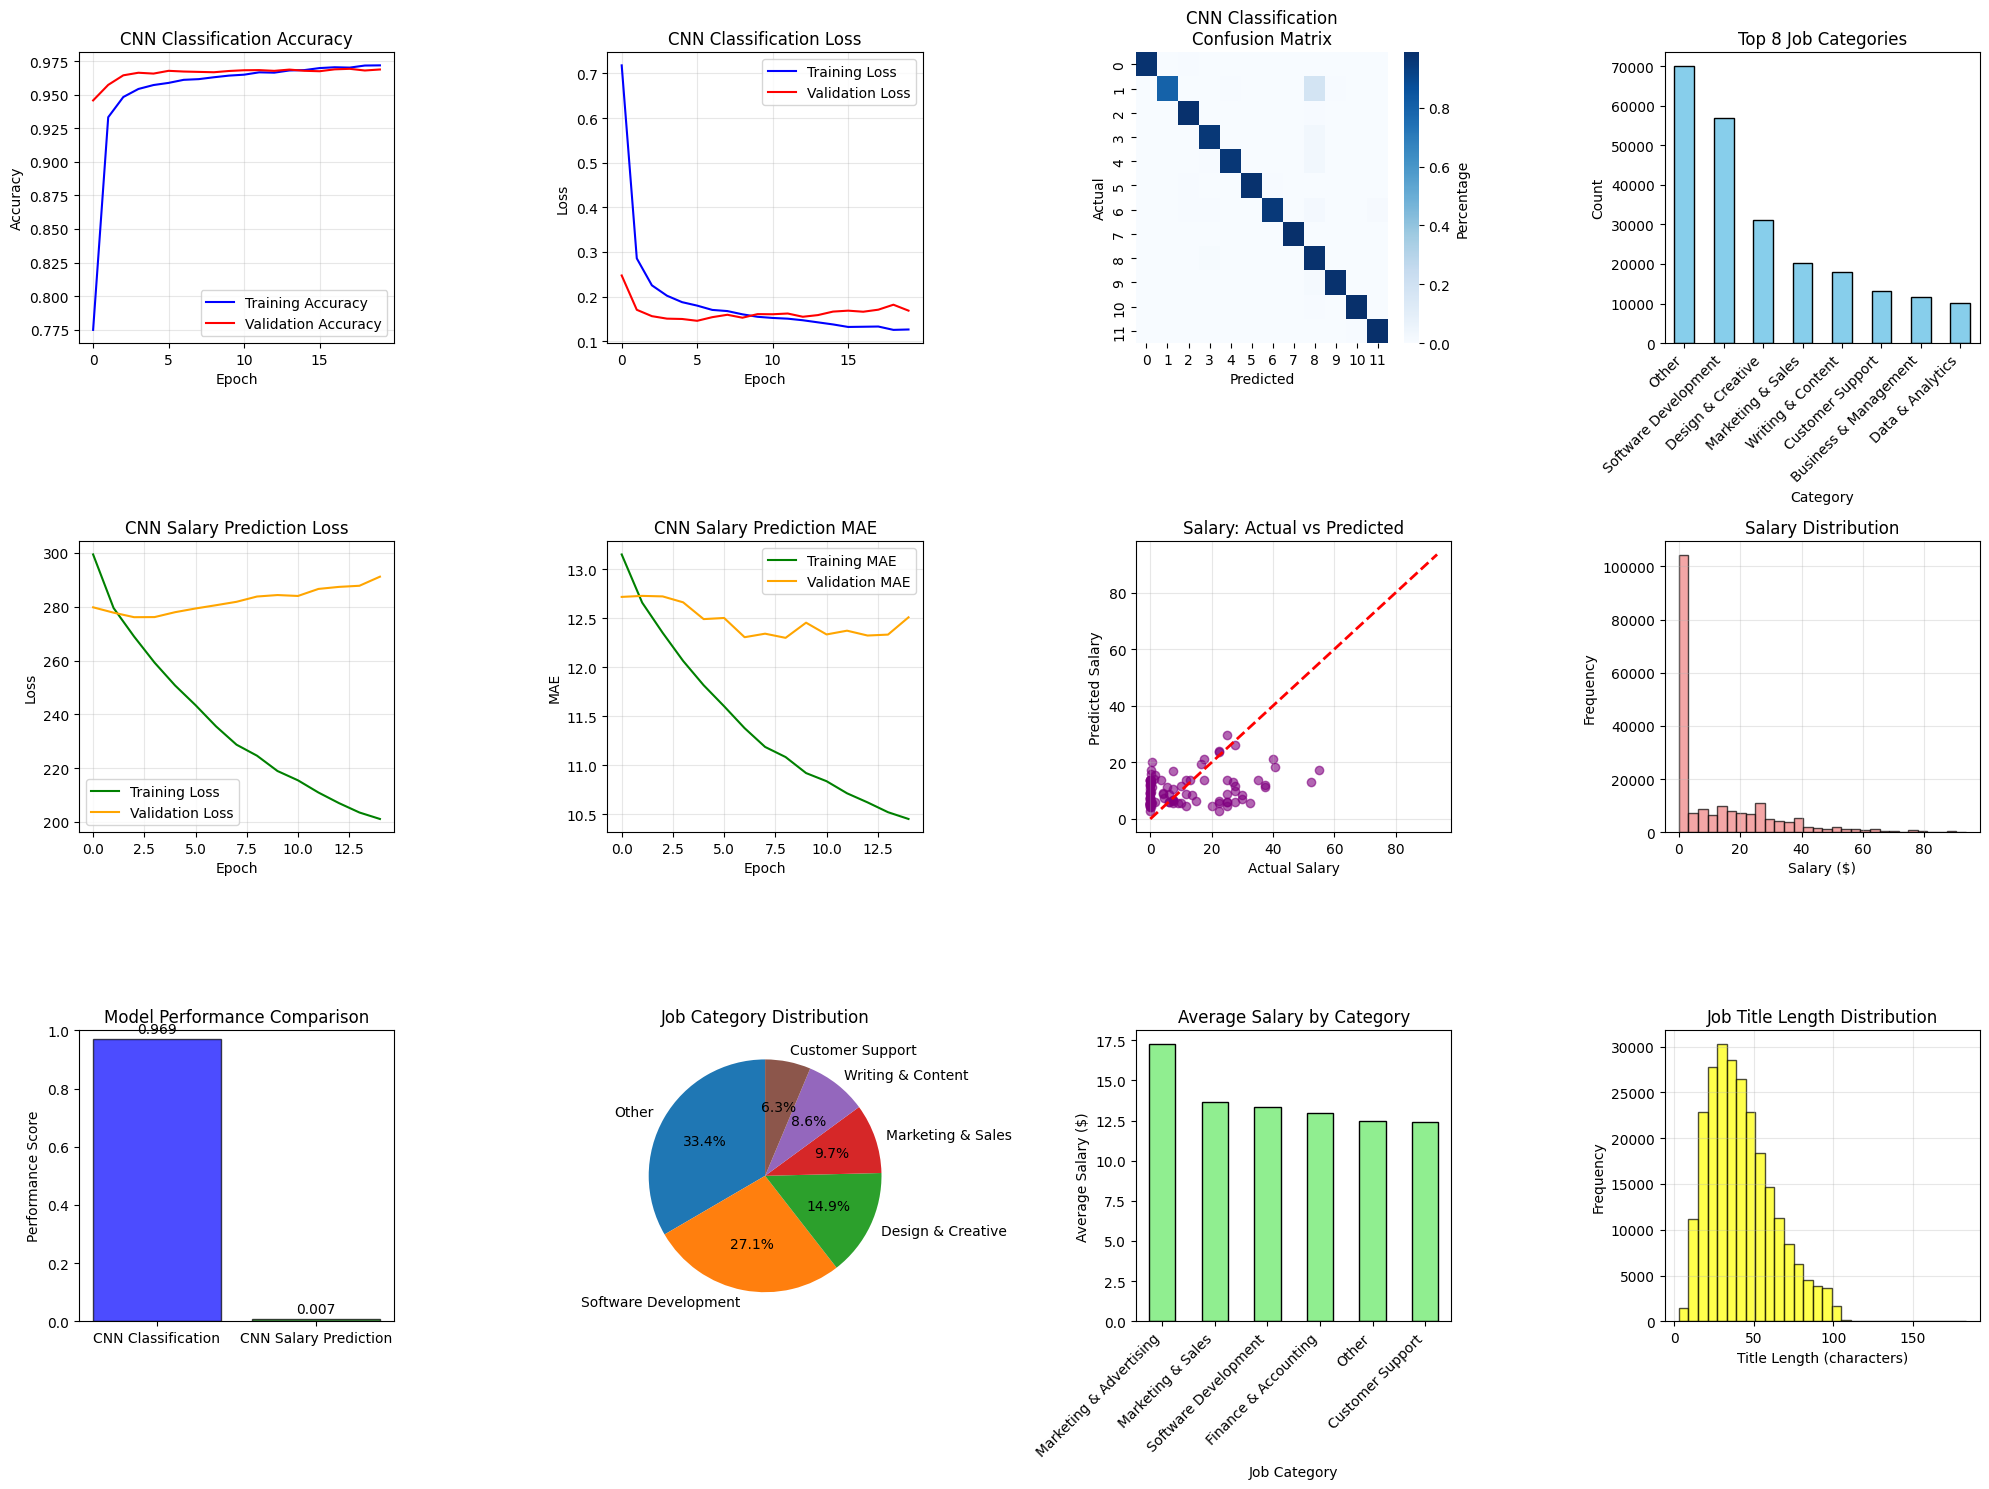

In [19]:
# VISUALIZATION OF ALL MODELS
print("\n" + "="*50)
print("COMPREHENSIVE MODEL VISUALIZATION")
print("="*50)

plt.figure(figsize=(20, 15))

# CNN Classification Results
plt.subplot(3, 4, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('CNN Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss', color='blue')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion Matrix for CNN
plt.subplot(3, 4, 3)
cm = confusion_matrix(y_test, cnn_pred_classes)
# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=False, cmap='Blues', cbar_kws={'label': 'Percentage'})
plt.title('CNN Classification\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Category Distribution
plt.subplot(3, 4, 4)
category_counts.head(8).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 8 Job Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Salary Prediction Results
plt.subplot(3, 4, 5)
plt.plot(history_salary.history['loss'], label='Training Loss', color='green')
plt.plot(history_salary.history['val_loss'], label='Validation Loss', color='orange')
plt.title('CNN Salary Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 6)
plt.plot(history_salary.history['mae'], label='Training MAE', color='green')
plt.plot(history_salary.history['val_mae'], label='Validation MAE', color='orange')
plt.title('CNN Salary Prediction MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Salary Predictions vs Actual
plt.subplot(3, 4, 7)
plt.scatter(y_sal_test[:100], salary_predictions[:100], alpha=0.6, color='purple')
plt.plot([y_sal_test.min(), y_sal_test.max()], [y_sal_test.min(), y_sal_test.max()], 'r--', lw=2)
plt.title('Salary: Actual vs Predicted')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.grid(True, alpha=0.3)

# Salary Distribution
plt.subplot(3, 4, 8)
plt.hist(salary_data['target_salary'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Salary Distribution')
plt.xlabel('Salary ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Model Comparison
plt.subplot(3, 4, 9)
models = ['CNN Classification', 'CNN Salary Prediction']
scores = [cnn_accuracy, 1 - (salary_mae / salary_data['target_salary'].mean())]  # Normalized salary accuracy
colors = ['blue', 'green']
bars = plt.bar(models, scores, color=colors, alpha=0.7, edgecolor='black')
plt.title('Model Performance Comparison')
plt.ylabel('Performance Score')
plt.ylim(0, 1)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

# Feature Importance (Top categories by frequency)
plt.subplot(3, 4, 10)
top_categories_freq = df_clean['job_category'].value_counts().head(6)
top_categories_freq.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Job Category Distribution')
plt.ylabel('')

# Hourly Rate by Category
if 'avg_hourly_rate' in salary_data.columns:
    plt.subplot(3, 4, 11)
    category_salary = salary_data.groupby('job_category')['target_salary'].mean().sort_values(ascending=False).head(6)
    category_salary.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title('Average Salary by Category')
    plt.xlabel('Job Category')
    plt.ylabel('Average Salary ($)')
    plt.xticks(rotation=45, ha='right')

# Text Length Distribution
plt.subplot(3, 4, 12)
df_clean['title_length'] = df_clean['title_original'].str.len()
plt.hist(df_clean['title_length'], bins=30, alpha=0.7, color='yellow', edgecolor='black')
plt.title('Job Title Length Distribution')
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_huggingface_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
# SAVE MODELS AND ARTIFACTS
print("\n Saving CNN models and artifacts...")

# Save CNN models
model_cnn.save('cnn_job_classifier.h5')
model_salary_cnn.save('cnn_salary_predictor.h5')



 Saving CNN models and artifacts...


In [22]:
# Save preprocessing artifacts
import joblib
joblib.dump(tokenizer_cnn, 'cnn_tokenizer.pkl')
joblib.dump(label_encoder, 'job_category_encoder.pkl')

print(" CNN models saved successfully")

# MODEL PERFORMANCE SUMMARY
print("\n" + "="*50)
print("CNN & HUGGING FACE MODELS SUMMARY")
print("="*50)

print(" CNN Job Category Classifier:")
print(f"   Accuracy: {cnn_accuracy:.4f}")
print(f"   Classes: {num_classes}")
print(f"   Training samples: {len(X_train):,}")

print(" CNN Salary Predictor:")
print(f"   MAE: ${salary_mae:.2f}")
print(f"   RMSE: ${salary_rmse:.2f}")
print(f"   Training samples: {len(X_sal_train):,}")

if HF_AVAILABLE:
    print(" Hugging Face Analysis:")
    print(f"   Sentiment analysis completed")
    print(f"   NER skills extraction attempted")
    print(f"   Job similarity analysis completed")
    if 'eval_results' in locals():
        print(f"  ✅ BERT fine-tuning completed")

print(" Data Processing:")
print(f"   Processed {len(df_clean):,} job postings")
print(f"   Vocabulary size: {max_words:,}")
print(f"   Sequence length: {max_length}")

print(f"\n CNN and Hugging Face model building completed!")

 CNN models saved successfully

CNN & HUGGING FACE MODELS SUMMARY
 CNN Job Category Classifier:
   Accuracy: 0.9695
   Classes: 12
   Training samples: 195,724
 CNN Salary Predictor:
   MAE: $12.51
   RMSE: $17.06
   Training samples: 162,540
 Hugging Face Analysis:
   Sentiment analysis completed
   NER skills extraction attempted
   Job similarity analysis completed
 Data Processing:
   Processed 244,655 job postings
   Vocabulary size: 5,000
   Sequence length: 50

 CNN and Hugging Face model building completed!
